# Train Bert for extractive summarization

In [1]:
import argparse
from time import time
import torch
import numpy as np
import random
import pandas as pd
from sklearn.utils import shuffle
from transformers import BertTokenizer, BertModel
import statistics
import os
from utils.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df

In [2]:
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__
    if shell == 'ZMQInteractiveShell':
      return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
      return False  # Terminal running IPython
    else:
      return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary and ner using bert')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=1)#32)
parser.add_argument('-epochs',type=int,default=100)
parser.add_argument('-dataset',type=str,default="data/nyt_corpus_LDC2008T19_50")

args = None

if is_notebook():
  args = parser.parse_args("")
else:
  args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
bert_layer = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# hyper-parameters
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
early_stopping = 3
model_name = "07-train_bertbase_ext_summary_NYT50"
sub_folder_name = "model_name__{}__time__{}__lr__{}__batch_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), learning_rate, batch_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
loss_sum_coef = 0.5
loss_ner_coef = 0.5
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 1


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
  # Display the number of available GPUs
  print(f"Number of available GPUs: {torch.cuda.device_count()}")
  # Display the name of each GPU
  for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
elif torch.backends.mps.is_available():
  print("MPS available.")
else:
  print("No GPU available.")

Number of available GPUs: 6
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080 Ti
GPU 3: NVIDIA GeForce GTX 1080
GPU 4: NVIDIA GeForce GTX 1080
GPU 5: NVIDIA GeForce GTX 1080


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
elif torch.backends.mps.is_available():
  dev = torch.device("mps")
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Load data

In [8]:
df_test = pd.read_json(args.dataset + "/test.json")
df_val = pd.read_json(args.dataset + "/val.json")
df_train = pd.read_json(args.dataset + "/train.json")

In [9]:
# Stats corpus

if False:
  len_articles = []

  for idx in df.index:
    txt = df["flat_contents"][idx]
    txt = sent_tokenize(txt)
    txt = " [SEP] ".join(txt)
    txt = bert_tokenizer.encode(txt, add_special_tokens=False)
    len_articles.append(len(txt))

  print("max:", max(len_articles), ", mediane:", statistics.median(len_articles), ", avg:", average(len_articles), ", std:", statistics.stdev(len_articles))
  # max: 184812 , mediane: 862.5 , avg: 2146.653203237274 , std: 4145.829631357804

In [10]:
df_train.head(2)

,paths,docs,summaries,labels
37290,data/nyt_corpus_LDC2008T19/nyt_corpus/data/199...,\n The Democratic leaders of the Assemb...,\n New York State Assembly Democratic l...,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
465243,data/nyt_corpus_LDC2008T19/nyt_corpus/data/200...,\n The arms expert at the center of a d...,"\n Dr David Kelly, arms expert at cente...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ..."


## Create dataset and dataloader

In [11]:
train_dataset = preprocess_df(df=df_train, bert_tokenizer=bert_tokenizer, block_size=512, trunc_doc=50, doc_column_name="docs", labels_sum_column_name="labels", is_sep_n=False)
val_dataset = preprocess_df(df=df_val, bert_tokenizer=bert_tokenizer, block_size=512, trunc_doc=50, doc_column_name="docs", labels_sum_column_name="labels", is_sep_n=False)
test_dataset = preprocess_df(df=df_test, bert_tokenizer=bert_tokenizer, block_size=512, trunc_doc=50, doc_column_name="docs", labels_sum_column_name="labels", is_sep_n=False)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, prop=0.3)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [13]:
import torch
import torch.nn as nn

class BertExtSUMNER(nn.Module):
  def __init__(self, bert_layer, bert_tokenizer, dim_emb=768) -> None:
    super(BertExtSUMNER, self).__init__()
    self.bert_layer = bert_layer
    self.bert_tokenizer = bert_tokenizer
    self.dim_emb = dim_emb

    # predict summary
    self.w_sum = nn.Linear(dim_emb, 1)
    
    # NER
    self.w_ner = nn.Linear(dim_emb, 1)

  def forward(self, list_input_ids, list_attention_mask):
    id_sep = bert_tokenizer.sep_token_id
    id_pad = bert_tokenizer.pad_token

    input_ids = []
    attention_mask = []

    for i in range(len(list_input_ids)):
      input_ids.append(list_input_ids[i].to(self.bert_layer.device))
      attention_mask.append(list_attention_mask[i].to(self.bert_layer.device))

    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)

    x = self.bert_layer(input_ids=input_ids, attention_mask=attention_mask)
    mask_sep = (input_ids == id_sep).view(-1)
    mask_not_sep = (torch.ne(input_ids, bert_tokenizer.pad_token_id) & torch.ne(input_ids, bert_tokenizer.sep_token_id)).view(-1)
    x = x.last_hidden_state
    x = x.view(-1, x.size(-1))
    emb_sent = x[mask_sep, :]
    emb_entities = x[mask_not_sep, :]

    o_sum = self.w_sum(emb_sent)
    o_sum = torch.sigmoid(o_sum).squeeze(-1)

    o_ner = self.w_ner(emb_entities)
    o_ner = torch.sigmoid(o_ner).squeeze(-1)

    return o_sum, o_ner

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

In [14]:
model = BertExtSUMNER(bert_layer=bert_layer, bert_tokenizer=bert_tokenizer)
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
criterion = nn.BCELoss()

## Train

In [17]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [18]:
df_val["doc_splitted"] = split_all_docs(df_val["docs"])
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [19]:
import math

arr_train_loss = []
arr_train_loss_sum = []
#arr_train_loss_ner = []
#arr_train_acc_sum = []
#arr_train_acc_ner = []
arr_val_loss = []
#arr_val_acc_sum = []
#arr_val_acc_ner = []

t1 = time()

for epoch in range(1, epochs+1):
  # Train
  model.train()
  nb_batch_train = 0
  nb_loss_train = 0
  total_train_loss = 0
  total_train_loss_sum = 0
  #total_train_loss_ner = 0
  #total_train_acc_sum = 0
  #total_train_acc_ner = 0
  
  id_sep = bert_tokenizer.sep_token_id
  id_pad = bert_tokenizer.pad_token

  for i in range(len(train_loader)):
    train_loader[i]

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #if dev != "cpu":
      #  torch.cuda.empty_cache()
      list_input_ids = batch["input_ids"]
      list_attention_mask = batch["attention_mask"]
      list_targets_sum = batch["labels"]
      #list_targets_ner = batch["labels_ner"]
      
      list_y_sum_pred = []
      #list_y_ner_pred = []
      for i in range(len(list_input_ids)):
        y_sum_pred, y_ner_pred = model(list_input_ids[i:i+1], list_attention_mask[i:i+1])

        loss_sum = criterion(y_sum_pred, torch.tensor(list_targets_sum[i], dtype=torch.float).to(device))
        #loss_ner = criterion(y_ner_pred, torch.tensor(list_targets_ner[i], dtype=torch.float).to(device))
        
        #loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner
        loss = loss_sum

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        nb_loss_train += 1
        total_train_loss += loss.item()
        total_train_loss_sum += loss_sum.item()
        #total_train_loss_ner += loss_ner.item()

        list_y_sum_pred.append(y_sum_pred.detach())
        #list_y_ner_pred.append(y_ner_pred.detach())

      nb_batch_train += 1

      y_sum_pred = torch.cat(list_y_sum_pred)
      #y_ner_pred = torch.cat(list_y_ner_pred)
      targets_sum = torch.cat([torch.tensor(e, dtype=torch.float).to(device) for e in list_targets_sum])
      #targets_ner = torch.cat([torch.tensor(e, dtype=torch.float).to(device) for e in list_targets_ner])

      probs = y_sum_pred.tolist() # compute_probs(y_pred)
      probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

      #total_train_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

      tepoch.set_postfix(loss=total_train_loss/nb_loss_train, loss_sum=total_train_loss_sum/nb_loss_train)

  # Save model
  model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

  # Eval
  model.eval()
  nb_batch_val = 0
  nb_loss_val = 0
  total_val_loss = 0
  total_val_loss_sum = 0
  #total_val_loss_ner = 0
  #total_val_acc_sum = 0
  #total_val_acc_ner = 0
  total_r1 = 0
  total_r2 = 0
  total_rl = 0

  del loss
  del loss_sum
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  for i, batch in enumerate(val_loader):
    #if dev != "cpu":
    #  torch.cuda.empty_cache()
    list_input_ids = batch["input_ids"]
    list_attention_mask = batch["attention_mask"]
    list_targets_sum = batch["labels"]

    list_y_sum_pred = []
    #list_y_ner_pred = []
    for j in range(len(list_input_ids)):
      y_sum_pred, y_ner_pred = model(list_input_ids[j:j+1], list_attention_mask[j:j+1])

      loss_sum = criterion(y_sum_pred, torch.tensor(list_targets_sum[j], dtype=torch.float).to(device))
      #loss_ner = criterion(y_ner_pred, torch.tensor(list_targets_ner[j], dtype=torch.float).to(device))
      
      #loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner
      loss = loss_sum

      nb_loss_val += 1      
      total_val_loss += loss.item()
      total_val_loss_sum += loss_sum.item()
      #total_val_loss_ner += loss_ner.item()

      list_y_sum_pred.append(y_sum_pred.detach())
      #list_y_ner_pred.append(y_ner_pred.detach())

    nb_batch_val += 1

    y_sum_pred = torch.cat(list_y_sum_pred)
    #y_ner_pred = torch.cat(list_y_ner_pred)
    targets_sum = torch.cat([torch.tensor(e, dtype=torch.float).to(device) for e in list_targets_sum])
    #targets_ner = torch.cat([torch.tensor(e, dtype=torch.float).to(device) for e in list_targets_ner])

    doc = val_set["doc_splitted"].iloc[i]
    summaries = val_set["summaries"].iloc[i]

    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    doc_lens = [len(doc)]
    for j in range(doc_lens[0]):
      txt = txt + ". " + doc[indices[j]]
      y_pred_thresh.append(indices[j])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for j in y_pred_thresh:
      txt = txt + ". " + doc[j]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    scores = scorer.score(summaries, txt)
    total_r1 += scores["rouge1"].recall
    total_r2 += scores["rouge2"].recall
    total_rl += scores["rougeL"].recall

    probs = y_sum_pred.tolist() # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #total_val_acc_sum += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #total_val_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

  print("Epoch {} : val loss = {:.3f}, val loss summary = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_loss_val, total_val_loss_sum / nb_loss_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

  if len(arr_val_loss) >= early_stopping+1:
    if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
      break

  del loss
  del loss_sum
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  arr_train_loss.append(total_train_loss / nb_batch_train)
  
  #arr_train_acc_sum.append(total_train_acc_sum / nb_batch_train)
  #arr_train_acc_ner.append(total_train_acc_ner / nb_batch_train)

  arr_val_loss.append(total_val_loss / nb_batch_val)
  #arr_val_acc_sum.append(total_val_acc_sum / nb_batch_val)
  #arr_val_acc_ner.append(total_val_acc_ner / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1: 100%|██████████| 30/30 [00:08<00:00,  3.52batch/s, loss=0.751, loss_sum=0.751]


Epoch 1 : val loss = 0.825, val loss summary = 0.825, r1 = 0.368, r2 = 0.152, rL = 0.248


Epoch 2: 100%|██████████| 30/30 [00:08<00:00,  3.37batch/s, loss=0.71, loss_sum=0.71]  


Epoch 2 : val loss = 0.708, val loss summary = 0.708, r1 = 0.390, r2 = 0.176, rL = 0.263


Epoch 3: 100%|██████████| 30/30 [00:07<00:00,  3.85batch/s, loss=0.703, loss_sum=0.703]


Epoch 3 : val loss = 0.703, val loss summary = 0.703, r1 = 0.390, r2 = 0.176, rL = 0.263


Epoch 4: 100%|██████████| 30/30 [00:08<00:00,  3.51batch/s, loss=0.703, loss_sum=0.703]


Epoch 4 : val loss = 0.692, val loss summary = 0.692, r1 = 0.384, r2 = 0.170, rL = 0.260


Epoch 5: 100%|██████████| 30/30 [00:08<00:00,  3.67batch/s, loss=0.703, loss_sum=0.703]


Epoch 5 : val loss = 0.692, val loss summary = 0.692, r1 = 0.359, r2 = 0.146, rL = 0.234


Epoch 6: 100%|██████████| 30/30 [00:08<00:00,  3.63batch/s, loss=0.706, loss_sum=0.706]


Epoch 6 : val loss = 0.691, val loss summary = 0.691, r1 = 0.394, r2 = 0.180, rL = 0.266


Epoch 7: 100%|██████████| 30/30 [00:09<00:00,  3.32batch/s, loss=0.698, loss_sum=0.698]


Epoch 7 : val loss = 0.708, val loss summary = 0.708, r1 = 0.390, r2 = 0.176, rL = 0.263


Epoch 8: 100%|██████████| 30/30 [00:08<00:00,  3.66batch/s, loss=0.701, loss_sum=0.701]


Epoch 8 : val loss = 0.692, val loss summary = 0.692, r1 = 0.390, r2 = 0.176, rL = 0.263


Epoch 9: 100%|██████████| 30/30 [00:08<00:00,  3.42batch/s, loss=0.697, loss_sum=0.697]


Epoch 9 : val loss = 0.695, val loss summary = 0.695, r1 = 0.390, r2 = 0.176, rL = 0.263


Epoch 10: 100%|██████████| 30/30 [00:08<00:00,  3.66batch/s, loss=0.705, loss_sum=0.705]


Epoch 10 : val loss = 0.710, val loss summary = 0.710, r1 = 0.369, r2 = 0.148, rL = 0.240
Training duration = 156.52455639839172


In [20]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
#training_metrics["train_acc_sum"]  = arr_train_acc_sum
#training_metrics["train_acc_ner"]  = arr_train_acc_ner
training_metrics["val_loss"]   = arr_val_loss
#training_metrics["val_acc_sum"]    = arr_val_acc_sum
#training_metrics["val_acc_ner"]    = arr_val_acc_ner

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
  json.dump(training_metrics, fp)

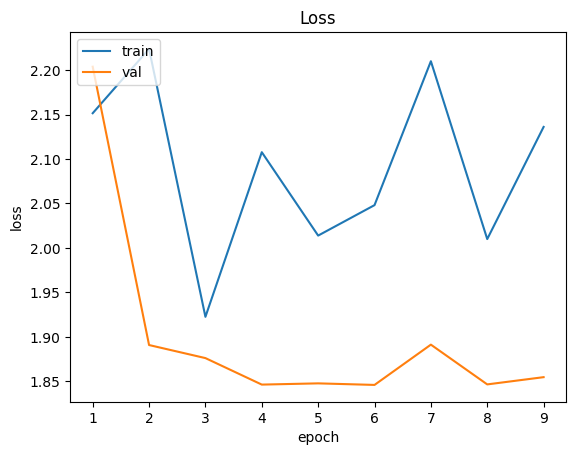

In [21]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

In [22]:
# draw Accuracies
if False and is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_sum) + 1)), arr_train_acc_sum, label="train")
  plt.plot(list(range(1, len(arr_val_acc_sum) + 1)), arr_val_acc_sum, label="val")

  plt.title("Accuracy Summary")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

In [23]:
# draw Accuracies
if False and is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_ner) + 1)), arr_train_acc_ner, label="train")
  plt.plot(list(range(1, len(arr_val_acc_ner) + 1)), arr_val_acc_ner, label="val")

  plt.title("Accuracy NER")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

## Eval Model

In [24]:
model = BertExtSUMNER(bert_layer=bert_layer, bert_tokenizer=bert_tokenizer)

In [25]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

6

In [26]:
df_test["doc_splitted"] = split_all_docs(df_test["docs"], False)
test_set = df_test

In [27]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()

In [28]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
arr_loss_sum = []
#arr_loss_ner = []
#accuracy_sum = []
#accuracy_ner = []

idx = 0

counter = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description("Eval model")
    list_input_ids = batch["input_ids"]
    list_attention_mask = batch["attention_mask"]
    list_targets_sum = batch["labels"]

    list_y_sum_pred = []
    #list_y_ner_pred = []
    for j in range(len(list_input_ids)):
      y_sum_pred, y_ner_pred = model(list_input_ids[j:j+1], list_attention_mask[j:j+1])

      loss_sum = criterion(y_sum_pred, torch.tensor(list_targets_sum[j], dtype=torch.float).to(device))
      #loss_ner = criterion(y_ner_pred, torch.tensor(list_targets_ner[j], dtype=torch.float).to(device))
    
      #loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner
      loss = loss_sum

      arr_loss.append(loss.item())
      arr_loss_sum.append(loss_sum.item())
      #arr_loss_ner.append(loss_ner.item())

      list_y_sum_pred.append(y_sum_pred.detach())
      #list_y_ner_pred.append(y_ner_pred.detach())

    y_sum_pred = torch.cat(list_y_sum_pred)
    #y_ner_pred = torch.cat(list_y_ner_pred)
    #targets_sum = torch.cat([torch.tensor(e, dtype=torch.float).to(device) for e in list_targets_sum])

    doc = test_set["doc_splitted"].iloc[idx]
    summaries = test_set["summaries"].iloc[idx]

    probs = np.array(y_sum_pred.tolist()) # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for i in range(min(len(doc), y_sum_pred.shape[0])):
      txt = txt + ". " + doc[indices[i]]
      y_pred_thresh.append(indices[i])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[i]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    # assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    arr_rouge1.append(scores["rouge1"].recall)
    arr_rouge2.append(scores["rouge2"].recall)
    arr_rougeL.append(scores["rougeL"].recall)

    #accuracy_sum.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
    #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))
    #accuracy_ner.append(torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0])

    tepoch.set_postfix(loss=np.mean(arr_loss), loss_sum=np.mean(arr_loss_sum), rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))
    idx += 1

Eval model: 100%|██████████| 100/100 [00:07<00:00, 13.28batch/s, loss=0.693, loss_sum=0.693, rouge1=0.375, rouge2=0.17, rougeL=0.256]


In [29]:
test_metrics = {}
#test_metrics["accuracy_sum"] = average(accuracy_sum)
#test_metrics["accuracy_ner"] = average(accuracy_ner)
test_metrics["rouge1"]   = np.mean(arr_rouge1)
test_metrics["rouge2"]   = np.mean(arr_rouge2)
test_metrics["rougeL"]   = np.mean(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
  json.dump(test_metrics, fp)

## Lead-3

In [30]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Lead-3")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(min(len(doc), 3)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        # assert len(txt) - len(summaries) <= 20

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

Lead-3:   0%|          | 0/100 [00:00<?, ?batch/s, rouge1=0.374, rouge2=0.208, rougeL=0.29]  

Lead-3: 100%|██████████| 100/100 [00:00<00:00, 128.70batch/s, rouge1=0.393, rouge2=0.217, rougeL=0.299]


## First n char

In [31]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("First-n-char'")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(len(doc)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

First-n-char': 100%|██████████| 100/100 [00:00<00:00, 109.66batch/s, rouge1=0.453, rouge2=0.25, rougeL=0.338]


In [32]:
# Does not execute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/raoufdine/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
